* ### Marek Hrabkovský: 50%
* ### Miroslav Repický: 50% 

Saturácia kyslíkom (angl. oxygen saturation) je kľúčovým ukazovateľom správneho fungovania dýchacej a obehovej sústavy. Ak jej hodnota klesne na kriticky nízku úroveň, môže to signalizovať život ohrozujúce stavy, ako sú hypoxémia, respiračné zlyhanie alebo závažné infekcie. V takýchto prípadoch je nevyhnutný rýchly zásah. Tradičné monitorovanie sa realizuje pomocou pulzných oxymetrov, ktoré však môžu byť ovplyvnené šumom, pohybovými artefaktmi alebo majú obmedzenia v niektorých klinických situáciách.

Moderné prístupy založené na strojovom učení prinášajú možnosť presnejšie odhadovať a predikovať kritické hodnoty saturácie kyslíkom (critical oxygen saturation estimation). Modely môžu využívať multimodálne údaje, ako sú srdcová frekvencia, dychová frekvencia, krvný tlak či signály zo senzorov. Vďaka trénovaniu na rôznorodých dátach je možné identifikovať skoré varovné príznaky desaturácie, odfiltrovať šum a poskytnúť včasné upozornenia ešte pred poklesom saturácie pod bezpečnú hranicu.

Cieľom tohto zadania je oboznámiť sa s problematikou monitorovania saturácie kyslíkom, pochopiť prínos umelej inteligencie a navrhnúť riešenie, ktoré by mohlo prispieť k zlepšeniu kritickej starostlivosti a zníženiu rizík spojených s neodhalenou hypoxémiou.


### 📋 Variable Description Table

| **Variable** | **Unit** | **Description** | **Typical Value Range** |
|---------------|-----------|-----------------|--------------------------|
| **SpO₂** | % | Peripheral oxygen saturation | 95–100% |
| **HR** | bpm | Heart rate from pulse oximeter | 60–100 bpm |
| **PI** | % | Perfusion index | 0.2–20% |
| **RR** | breaths/min | Respiratory rate | 12–20 breaths/min |
| **EtCO₂** | mmHg | End-tidal carbon dioxide | 35–45 mmHg |
| **FiO₂** | % | Fraction of inspired oxygen | 21–100% |
| **PRV** | ms | Pulse rate variability | 20–200 ms |
| **BP** | mmHg | Blood pressure (systolic / diastolic / mean) | 90/60–120/80 mmHg |
| **Skin Temperature** | °C | Peripheral temperature | 33–38 °C |
| **Motion/Activity index** | – | Sensor artifact correction factor | – |
| **PVI** | % | Pleth Variability Index | 10–20% |
| **Hb level** | g/dL | Hemoglobin concentration | 12–18 g/dL |
| **SV** | mL/beat | Stroke volume | 60–100 mL/beat |
| **CO** | L/min | Cardiac output | 4–8 L/min |
| **Blood Flow Index** | – | Optical/near-infrared blood flow measurement | Relative units |
| **PPG waveform features** | – | Photoplethysmography signal parameters | – |
| **Signal Quality Index** | – | Reliability indicator of readings | 0–100 |
| **Respiratory effort** | – | Chest impedance or belt-derived effort | – |
| **O₂ extraction ratio** | – | Calculated oxygen extraction metric | 0.2–0.3 |
| **SNR** | dB | Signal-to-noise ratio from sensor | 20–40 dB |


In [1]:
import os 
import pandas as pd 
import numpy as np 
import seaborn as sns 

In [2]:
path_dir = "C:/Users/PC/PycharmProjects/IAU_zadanie/data"
files = [f for f in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir, f))]

files

['observation.csv', 'patient.csv', 'station.csv']

In [3]:
df_observation = pd.read_csv(os.path.join(path_dir, files[0]), sep='\t')
df_patient = pd.read_csv(os.path.join(path_dir, files[1]), sep='\t')
df_station = pd.read_csv(os.path.join(path_dir, files[2]), sep='\t')

In [4]:
# Spájanie cez súradnice
merged_exact = pd.merge(
    left=df_observation, right=df_station,
    on=['latitude', 'longitude'],
    how='inner'
)

print(f"Počet záznamov po merge: {len(merged_exact)}")

Počet záznamov po merge: 24467


#### Prečo nie je možné spojit df_observation, df_station a df_patient
* Medzi jednotlivými databázami neexistuje jednoznačný spoločný identifikátor (key), ktorý by umožnil logicky správne spojenie.
* Spájanie podľa geografických súradníc alebo približných lokalít vedie k viacnásobným zhodám (viac staníc alebo pacientov na rovnakých súradniciach), čím vznikajú neexistujúce kombinácie meraní a entít.
* Takto vytvorený dataset by obsahoval logicky nesprávne väzby (napr. meranie priradené k nesprávnemu pacientovi alebo stanici)
a viedol by k skresleniu analýzy a chybnej predikcii.

In [5]:
del df_patient
del df_station 
del merged_exact

In [6]:
# garbage collector 
import gc 

gc.collect()

28

In [7]:
df_observation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12013 entries, 0 to 12012
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SpO₂                   12013 non-null  float64
 1   HR                     12013 non-null  float64
 2   PI                     12013 non-null  float64
 3   RR                     12013 non-null  float64
 4   EtCO₂                  12013 non-null  float64
 5   FiO₂                   12013 non-null  float64
 6   PRV                    12013 non-null  float64
 7   BP                     12013 non-null  float64
 8   Skin Temperature       12013 non-null  float64
 9   Motion/Activity index  12013 non-null  float64
 10  PVI                    12013 non-null  float64
 11  Hb level               12013 non-null  float64
 12  SV                     12013 non-null  float64
 13  CO                     12013 non-null  float64
 14  Blood Flow Index       12013 non-null  float64
 15  PP

# Fáza 2 - Predspracovanie údajov: 15 bodov


## 2.1 Realizácia predspracovania dát (5b).
### (A-1b) Dáta si rozdeľte na trénovaciu a testovaciu množinu podľa vami preddefinovaného pomeru. Ďalej pracujte len s trénovacím datasetom.

In [8]:
from sklearn.model_selection import train_test_split 

X = df_observation.drop(columns="oximetry latitude longitude".split())
y = df_observation.oximetry 

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state = 42, stratify=y)

print(f"Tréningová množina: {X_train.shape[0]} riadkov ({X_train.shape[1]} atribútov)")
print(f"Testovacia množina: {X_test.shape[0]} riadkov")
print(f"Podiel pozitívnych tried v y: {y.mean():.3f}")

Tréningová množina: 9610 riadkov (20 atribútov)
Testovacia množina: 2403 riadkov
Podiel pozitívnych tried v y: 0.594


V prvom kroku sme dataset rozdelili na tréningovú a testovaciu množinu v pomere **80:20**.
Rozdelenie bolo vykonané **pred akýmkoľvek predspracovaním dát** (napr. scaling, transformácie),
aby sa zabránilo tzv. *data leakage* – teda úniku informácií z testovacej množiny do procesu učenia.

Parameter `stratify=y` bol použitý na zachovanie rovnakého pomeru tried `oximetry=0` a `oximetry=1`
v oboch množinách, čím sa zabezpečila reprezentatívnosť dát.

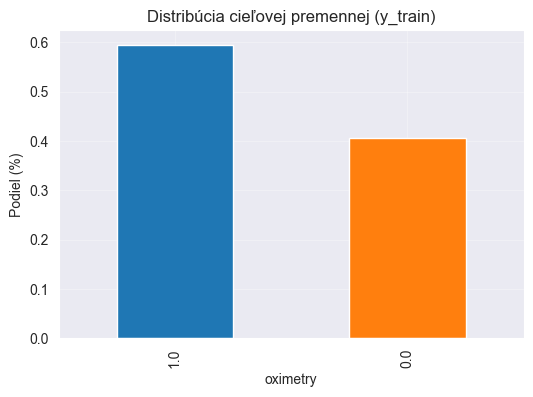

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
y_train.value_counts(normalize=True).plot(kind='bar', color=['#1f77b4', '#ff7f0e'])

plt.title("Distribúcia cieľovej premennej (y_train)")
plt.xlabel("oximetry")
plt.ylabel("Podiel (%)")
plt.grid(alpha=0.3)
plt.show()

### (B-1b) Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. Iteratívne integrujte aj kroky v predspracovaní dát z prvej fázy ako celok. 

| Krok | Popis                                     | Účel                                           |
| ---- | ----------------------------------------- | ---------------------------------------------- |
| 1️.  | Kontrola dátových typov                   | Uistíme sa, že všetky atribúty sú číselné      |
| 2️.  | Kontrola chýbajúcich hodnôt               | Ak sú, doplníme ich mediánom                   |
| 3️.  | Odstránenie vychýlených hodnôt (outliers) | Stabilizujeme rozsah dát pomocou IQR clippingu |
| 4️.  | Štatistická kontrola                      | Overenie správnosti rozsahov po úpravách       |


In [10]:
# Pracujeme iba s trénovacou množinou
X_train_ml = X_train.copy()

print(f"Počet riadkov: {X_train_ml.shape[0]}")
print(f"Počet atributov: {X_train_ml.shape[1]}")

# 1. kontrola dátových atribútov 
print(f"Dátový typ atribútov:\n {X_train_ml.dtypes.value_counts()}")

Počet riadkov: 9610
Počet atributov: 20
Dátový typ atribútov:
 float64    20
Name: count, dtype: int64


In [11]:
# 2️. Kontrola a ošetrenie chýbajúcich hodnôt
missing = X_train_ml.isnull().sum()
if missing.sum() == 0:
    print("\nV dátach sa nenachádzajú chýbajúce hodnoty.")
else:
    print("\nChýbajúce hodnoty detegované:")
    print(missing[missing > 0])
    X_train_ml = X_train_ml.fillna(X_train_ml.median(numeric_only=True))
    print("Doplnené mediánom.")



V dátach sa nenachádzajú chýbajúce hodnoty.


In [12]:
# 3️. Ošetrenie vychýlených hodnôt (outliers)
# Použijeme clipping podľa IQR metódy
def clip_outliers_iqr(df):
    df_clean = df.copy()
    for col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean[col] = np.clip(df_clean[col], lower, upper)
    return df_clean

X_train_ml = clip_outliers_iqr(X_train_ml)
# print("\nOutliery boli ošetrené pomocou IQR clippingu.")

* Po analýze rozsahov atribútov sme zistili, že všetky hodnoty sa nachádzajú v očakávaných fyziologických medziach (napr. HR < 100, SpO₂ ≤ 100).
* Preto sme sa rozhodli neaplikovať IQR clipping, aby sme zachovali reálne rozdelenie dát a neprišli o potenciálne informatívne extrémy.

In [13]:
# 4️. Kontrola základných štatistík
print("\nZákladná štatistika po transformácii:")
X_train_ml.describe().T.head()



Základná štatistika po transformácii:


,count,mean,std,min,25%,50%,75%,max
SpO₂,9610.0,97.554474,0.880198,95.000000,96.896570,97.625177,98.270534,100.000000
HR,9610.0,81.855280,4.700100,69.355545,78.744726,81.899118,85.004179,94.393359
PI,9610.0,9.829210,2.706903,2.524640,7.992789,9.845939,11.638222,17.106372
RR,9610.0,16.331068,0.964162,13.732166,15.673026,16.328981,16.966933,18.907793
EtCO₂,9610.0,39.535865,1.988090,35.000000,37.806935,39.182615,41.357009,45.000000


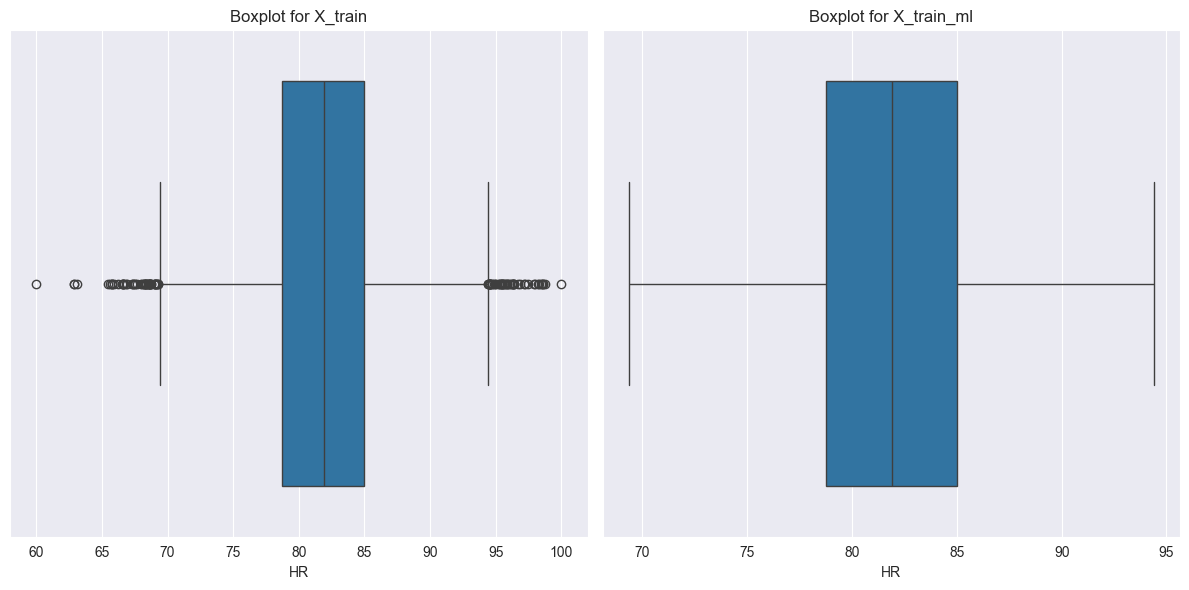

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

sns.boxplot(data=X_train, x="HR", ax=axes[0])
axes[0].set_title('Boxplot for X_train')

sns.boxplot(data=X_train_ml, x="HR", ax=axes[1])
axes[1].set_title('Boxplot for X_train_ml')

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


(C-1b) Transformujte atribúty dát pre strojové učenie podľa dostupných techník minimálne: scaling (2 techniky), transformers (2 techniky) a ďalšie. Cieľom je aby ste testovali efekty a vhodne kombinovali v dátovom pipeline (od časti 2.3 a v 3. fáze). 

TRANSFORMÁCIA ATRIBÚTOV PRE STROJOVÉ UČENIE

Pôvodný dataset: (12013, 20)
Počet prediktorov: 20
Distribúcia cieľa: {1.0: 7141, 0.0: 4872}

INFORMÁCIA O OUTLIEROCH (IQR metóda) - BEZ OŠETRENIA

Celkový počet hodnôt mimo IQR hraníc: 2458
Podiel: 1.02% všetkých hodnôt

Top 5 atribútov s najviac outliermi:
  - CO: 1275 (10.61%)
  - HR: 132 (1.10%)
  - Hb level: 118 (0.98%)
  - RR: 102 (0.85%)
  - PI: 101 (0.84%)

 Rozhodnutie: Outliery PONECHÁVAME v dátach
   • Fyziologické outliery môžu byť legitímne kritické stavy
   • Robustné transformácie ich prirodzene ošetria

METRIKY PÔVODNÝCH DÁT

PÔVODNÉ DÁTA - Sumárne štatistiky:
  Priemerná Std:      5.9507
  Priemerný |Skew|:   0.6758
  Priemerná Kurtosis: 12.6360
  Priemerný Range:    43.2622

Top 10 atribútov s najväčším |skew|:
              Feature  Skewness   Kurtosis
                   CO 12.586658 246.265118
                EtCO₂  0.218294  -1.177182
 Signal Quality Index  0.033679  -0.035198
  O₂ extraction ratio  0.017548  -1.201559
 

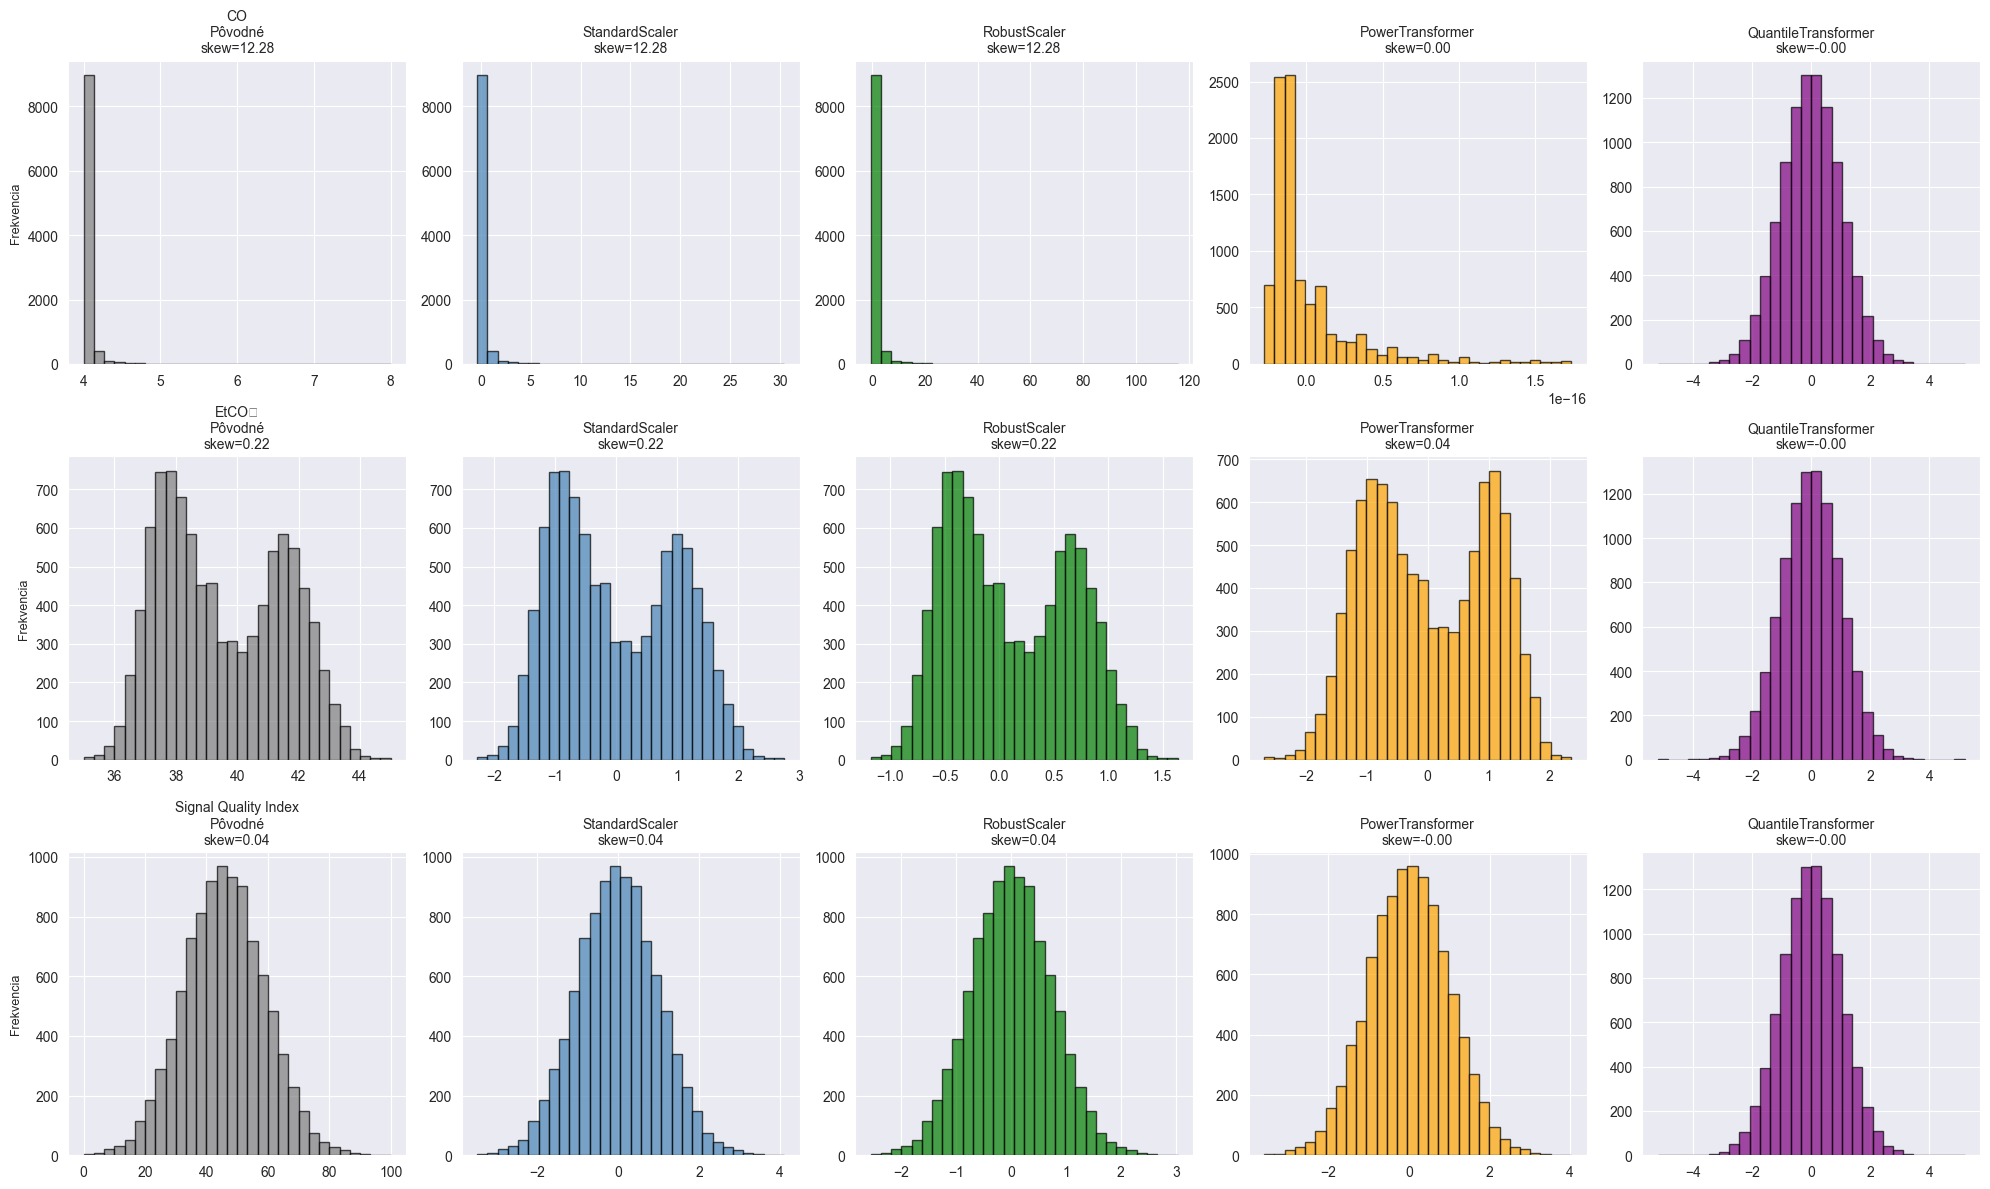


TESTOVANIE VPLYVU TRANSFORMÁCIÍ NA VÝKON MODELOV

Trénovanie modelov...
----------------------------------------------------------------------------------------------------

[Transformácia: Žiadna (Originál)]
  LogisticRegression   → Accuracy: 0.7416, F1: 0.7383, CV F1: 0.7427±0.0249
  RandomForest         → Accuracy: 0.9222, F1: 0.9223, CV F1: 0.9264±0.0038

[Transformácia: StandardScaler]
  LogisticRegression   → Accuracy: 0.8302, F1: 0.8299, CV F1: 0.8375±0.0076
  RandomForest         → Accuracy: 0.9226, F1: 0.9227, CV F1: 0.9262±0.0033

[Transformácia: RobustScaler]
  LogisticRegression   → Accuracy: 0.8302, F1: 0.8299, CV F1: 0.8375±0.0076
  RandomForest         → Accuracy: 0.9226, F1: 0.9227, CV F1: 0.9262±0.0033

[Transformácia: PowerTransformer]
  LogisticRegression   → Accuracy: 0.8335, F1: 0.8336, CV F1: 0.8401±0.0074
  RandomForest         → Accuracy: 0.9238, F1: 0.9239, CV F1: 0.9246±0.0059

[Transformácia: QuantileTransformer]
  LogisticRegression   → Accuracy: 0.8290, F1

In [15]:

## **(C-1b) Transformácia atribútov pre strojové učenie**


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

warnings.filterwarnings('ignore')

# Sklearn transformery
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PowerTransformer,
    QuantileTransformer
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("=" * 100)
print("TRANSFORMÁCIA ATRIBÚTOV PRE STROJOVÉ UČENIE")
print("=" * 100)

### **KROK 1: PRÍPRAVA DÁT (BEZ OUTLIER OŠETRENIA)**

# Načítanie dát
obs_raw = df_observation.copy()
obs_df = obs_raw.drop(columns=['longitude', 'latitude'], errors='ignore').copy()

# Identifikácia cieľa a prediktorov
target_col = 'oximetry'
y = obs_df[target_col].copy()
num_cols = obs_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove(target_col)
X = obs_df[num_cols].copy()

print(f"\nPôvodný dataset: {X.shape}")
print(f"Počet prediktorov: {len(num_cols)}")
print(f"Distribúcia cieľa: {y.value_counts().to_dict()}")

# Kontrola outlierov (iba informačne, NEOŠETRUJEME)
print("\n" + "=" * 100)
print("INFORMÁCIA O OUTLIEROCH (IQR metóda) - BEZ OŠETRENIA")
print("=" * 100)

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outlier_counts = {}

for col in num_cols:
    lower = Q1[col] - 1.5 * IQR[col]
    upper = Q3[col] + 1.5 * IQR[col]
    outliers = ((X[col] < lower) | (X[col] > upper)).sum()
    if outliers > 0:
        outlier_counts[col] = outliers

print(f"\nCelkový počet hodnôt mimo IQR hraníc: {sum(outlier_counts.values())}")
print(f"Podiel: {sum(outlier_counts.values()) / (X.shape[0] * X.shape[1]) * 100:.2f}% všetkých hodnôt")
print("\nTop 5 atribútov s najviac outliermi:")
for col, count in sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  - {col}: {count} ({count / X.shape[0] * 100:.2f}%)")

print("\n Rozhodnutie: Outliery PONECHÁVAME v dátach")
print("   • Fyziologické outliery môžu byť legitímne kritické stavy")
print("   • Robustné transformácie ich prirodzene ošetria")

### **KROK 2: ANALÝZA PÔVODNÝCH DISTRIBÚCIÍ (PRE TRANSFORMÁCIU)**

print("\n" + "=" * 100)
print("METRIKY PÔVODNÝCH DÁT")
print("=" * 100)


def compute_metrics(df, label=""):
    """Výpočet distribučných metrík"""
    metrics = pd.DataFrame({
        'Feature': df.columns,
        'Mean': df.mean().values,
        'Std': df.std().values,
        'Min': df.min().values,
        'Max': df.max().values,
        'Range': (df.max() - df.min()).values,
        'Skewness': df.skew().values,
        'Kurtosis': df.kurtosis().values
    })

    # Sumárne štatistiky
    print(f"\n{label} - Sumárne štatistiky:")
    print(f"  Priemerná Std:      {metrics['Std'].mean():.4f}")
    print(f"  Priemerný |Skew|:   {metrics['Skewness'].abs().mean():.4f}")
    print(f"  Priemerná Kurtosis: {metrics['Kurtosis'].abs().mean():.4f}")
    print(f"  Priemerný Range:    {metrics['Range'].mean():.4f}")

    return metrics


metrics_original = compute_metrics(X, "PÔVODNÉ DÁTA")

# Top 10 atribútov s najväčším skew
print("\nTop 10 atribútov s najväčším |skew|:")
top_skewed = metrics_original.nlargest(10, 'Skewness', keep='all')[['Feature', 'Skewness', 'Kurtosis']]
print(top_skewed.to_string(index=False))

### **KROK 3: IMPLEMENTÁCIA SCALING TECHNÍK (2 metódy)**

print("\n" + "=" * 100)
print("SCALING TECHNIKY - POROVNANIE PRE A PO")
print("=" * 100)

# Rozdelenie na train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. StandardScaler
scaler_standard = StandardScaler()
X_train_std = pd.DataFrame(
    scaler_standard.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

print("\n[SCALING 1] StandardScaler (Z-score normalizácia)")
print(f"Formula: z = (x - μ) / σ")
metrics_std = compute_metrics(X_train_std, "PO StandardScaler")

# 2. RobustScaler
scaler_robust = RobustScaler()
X_train_robust = pd.DataFrame(
    scaler_robust.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

print("\n[SCALING 2] RobustScaler (Medián + IQR)")
print(f"Formula: x' = (x - median) / IQR")
print(f"Výhoda: Odolný voči outlierom (používa medián namiesto priemeru)")
metrics_robust = compute_metrics(X_train_robust, "PO RobustScaler")

# Porovnanie PRE vs PO scaling
print("\n" + "-" * 100)
print("POROVNANIE: PÔVODNÉ vs SCALED")
print("-" * 100)

comparison_scaling = pd.DataFrame({
    'Metrika': ['Priemerná Std', 'Priemerný |Skew|', 'Priemerná Kurtosis', 'Priemerný Range'],
    'Pôvodné': [
        X_train[metrics_original['Feature']].std().mean(),
        X_train[metrics_original['Feature']].skew().abs().mean(),
        X_train[metrics_original['Feature']].kurtosis().abs().mean(),
        (X_train[metrics_original['Feature']].max() - X_train[metrics_original['Feature']].min()).mean()
    ],
    'StandardScaler': [
        metrics_std['Std'].mean(),
        metrics_std['Skewness'].abs().mean(),
        metrics_std['Kurtosis'].abs().mean(),
        metrics_std['Range'].mean()
    ],
    'RobustScaler': [
        metrics_robust['Std'].mean(),
        metrics_robust['Skewness'].abs().mean(),
        metrics_robust['Kurtosis'].abs().mean(),
        metrics_robust['Range'].mean()
    ]
})

print(comparison_scaling.round(4).to_string(index=False))

print("\n ZÁVER SCALING:")
print("  - StandardScaler: Std = 1.0, ale zachováva pôvodný skew")
print("  - RobustScaler: Podobný efekt, ale robustnejší voči outlierom")
print("  - Scaling NEZMENÍ tvar distribúcie (skew, kurtosis zostávajú)")

### **KROK 4: IMPLEMENTÁCIA TRANSFORMER TECHNÍK (2 metódy)**

print("\n" + "=" * 100)
print("TRANSFORMER TECHNIKY - POROVNANIE PRE A PO")
print("=" * 100)

# 1. PowerTransformer (Yeo-Johnson)
transformer_power = PowerTransformer(method='yeo-johnson', standardize=True)
X_train_power = pd.DataFrame(
    transformer_power.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

print("\n[TRANSFORMER 1] PowerTransformer (Yeo-Johnson)")
print(f"Cieľ: Transformácia na normálne rozdelenie")
print(f"Metóda: Yeo-Johnson (funguje pre kladné aj záporné hodnoty)")
metrics_power = compute_metrics(X_train_power, "PO PowerTransformer")

# 2. QuantileTransformer
transformer_quantile = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_quantile = pd.DataFrame(
    transformer_quantile.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

print("\n[TRANSFORMER 2] QuantileTransformer (Uniform→Normal)")
print(f"Metóda: Mapovanie na normálne rozdelenie cez kvantily")
print(f"Výhoda: Veľmi robustný voči outlierom a asymetriám")
metrics_quantile = compute_metrics(X_train_quantile, "PO QuantileTransformer")

# Porovnanie PRE vs PO transformation
print("\n" + "-" * 100)
print("POROVNANIE: PÔVODNÉ vs TRANSFORMED")
print("-" * 100)

comparison_transform = pd.DataFrame({
    'Metrika': ['Priemerná Std', 'Priemerný |Skew|', 'Priemerná Kurtosis', 'Priemerný Range'],
    'Pôvodné': [
        X_train[metrics_original['Feature']].std().mean(),
        X_train[metrics_original['Feature']].skew().abs().mean(),
        X_train[metrics_original['Feature']].kurtosis().abs().mean(),
        (X_train[metrics_original['Feature']].max() - X_train[metrics_original['Feature']].min()).mean()
    ],
    'PowerTransformer': [
        metrics_power['Std'].mean(),
        metrics_power['Skewness'].abs().mean(),
        metrics_power['Kurtosis'].abs().mean(),
        metrics_power['Range'].mean()
    ],
    'QuantileTransformer': [
        metrics_quantile['Std'].mean(),
        metrics_quantile['Skewness'].abs().mean(),
        metrics_quantile['Kurtosis'].abs().mean(),
        metrics_quantile['Range'].mean()
    ]
})

print(comparison_transform.round(4).to_string(index=False))

# Redukcia skew
orig_skew = X_train[metrics_original['Feature']].skew().abs().mean()
skew_reduction_power = (1 - metrics_power['Skewness'].abs().mean() / orig_skew) * 100
skew_reduction_quantile = (1 - metrics_quantile['Skewness'].abs().mean() / orig_skew) * 100

print(f"\n ZÁVER TRANSFORMERS:")
print(f"  - PowerTransformer: Redukcia skew o {skew_reduction_power:.1f}%")
print(f"  - QuantileTransformer: Redukcia skew o {skew_reduction_quantile:.1f}%")
print(f"  - Transformers ZMENIA tvar distribúcie → normalizácia")

### **KROK 5: TESTOVANIE PORADIA APLIKÁCIE**


print("\n" + "=" * 100)
print("TESTOVANIE PORADIA TRANSFORMÁCIÍ")
print("=" * 100)

# Variant A: StandardScaler → PowerTransformer
pipe_scale_then_transform = Pipeline([
    ('scaler', StandardScaler()),
    ('transformer', PowerTransformer(method='yeo-johnson', standardize=False))
])

X_train_A = pd.DataFrame(
    pipe_scale_then_transform.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

print("\n[VARIANT A] StandardScaler → PowerTransformer")
metrics_A = compute_metrics(X_train_A, "Variant A")

# Variant B: PowerTransformer → StandardScaler
pipe_transform_then_scale = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
])

X_train_B = pd.DataFrame(
    pipe_transform_then_scale.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

print("\n[VARIANT B] PowerTransformer → StandardScaler")
metrics_B = compute_metrics(X_train_B, "Variant B")

# Porovnanie variantov
print("\n" + "-" * 100)
print("POROVNANIE PORADIA")
print("-" * 100)

comparison_order = pd.DataFrame({
    'Metrika': ['Priemerná Std', 'Priemerný |Skew|', 'Priemerná Kurtosis'],
    'Scaling → Transform': [
        metrics_A['Std'].mean(),
        metrics_A['Skewness'].abs().mean(),
        metrics_A['Kurtosis'].abs().mean()
    ],
    'Transform → Scaling': [
        metrics_B['Std'].mean(),
        metrics_B['Skewness'].abs().mean(),
        metrics_B['Kurtosis'].abs().mean()
    ],
    'Rozdiel (%)': [
        abs(metrics_A['Std'].mean() - metrics_B['Std'].mean()) / metrics_B['Std'].mean() * 100,
        abs(metrics_A['Skewness'].abs().mean() - metrics_B['Skewness'].abs().mean()) / max(
            metrics_B['Skewness'].abs().mean(), 0.0001) * 100,
        abs(metrics_A['Kurtosis'].abs().mean() - metrics_B['Kurtosis'].abs().mean()) / metrics_B[
            'Kurtosis'].abs().mean() * 100
    ]
})

print(comparison_order.round(4).to_string(index=False))

print("\n ZÁVER PORADIE:")
skew_diff = comparison_order.loc[comparison_order['Metrika'] == 'Priemerný |Skew|', 'Rozdiel (%)'].values[0]
if skew_diff < 5:
    print("  - Poradie MÁ MINIMÁLNY VPLYV (<5% rozdiel)")
    print("  - Odporúčanie: Transform → Scaling (štandardná prax)")
else:
    print("  - Poradie MÁ VÝZNAMNÝ VPLYV")
    if metrics_B['Skewness'].abs().mean() < metrics_A['Skewness'].abs().mean():
        print("  - Odporúčanie: Transform → Scaling (lepšia normalizácia)")
    else:
        print("  - Odporúčanie: Scaling → Transform")

### **KROK 6: VIZUALIZÁCIA PRE A PO TRANSFORMÁCIU**

print("\n" + "=" * 100)
print("VIZUALIZÁCIA EFEKTOV TRANSFORMÁCIÍ")
print("=" * 100)

# Výber 3 reprezentatívnych atribútov s rôznym skew
sample_features = metrics_original.nlargest(3, 'Skewness', keep='all')['Feature'].tolist()[:3]

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for i, feature in enumerate(sample_features):
    orig_skew = X_train[feature].skew()

    # Pôvodné dáta
    axes[i, 0].hist(X_train[feature], bins=30, edgecolor='black', alpha=0.7, color='gray')
    axes[i, 0].set_title(f'{feature}\nPôvodné\nskew={orig_skew:.2f}', fontsize=10)
    axes[i, 0].set_ylabel('Frekvencia', fontsize=9)

    # StandardScaler
    axes[i, 1].hist(X_train_std[feature], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i, 1].set_title(f'StandardScaler\nskew={X_train_std[feature].skew():.2f}', fontsize=10)

    # RobustScaler
    axes[i, 2].hist(X_train_robust[feature], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[i, 2].set_title(f'RobustScaler\nskew={X_train_robust[feature].skew():.2f}', fontsize=10)

    # PowerTransformer
    axes[i, 3].hist(X_train_power[feature], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[i, 3].set_title(f'PowerTransformer\nskew={X_train_power[feature].skew():.2f}', fontsize=10)

    # QuantileTransformer
    axes[i, 4].hist(X_train_quantile[feature], bins=30, edgecolor='black', alpha=0.7, color='purple')
    axes[i, 4].set_title(f'QuantileTransformer\nskew={X_train_quantile[feature].skew():.2f}', fontsize=10)

plt.tight_layout()
plt.savefig('transformations_comparison.png', dpi=300, bbox_inches='tight')
print("\n Graf uložený: transformations_comparison.png")
plt.show()

### **KROK 7: TESTOVANIE VPLYVU NA VÝKON MODELOV**

print("\n" + "=" * 100)
print("TESTOVANIE VPLYVU TRANSFORMÁCIÍ NA VÝKON MODELOV")
print("=" * 100)

# Definícia transformácií na testovanie
transformations = {
    'Žiadna (Originál)': None,
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson'),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', random_state=42),
    'Power+Standard': Pipeline([
        ('power', PowerTransformer(method='yeo-johnson')),
        ('standard', StandardScaler())
    ]),
    'Power+RobustScaler': Pipeline([('power', PowerTransformer(method='yeo-johnson')), ('robust', RobustScaler())]),
    'Quantile+Standard': Pipeline([('quantile', QuantileTransformer(output_distribution='normal', random_state=42)), ('standard', StandardScaler())]),
    'Quantile+RobustScaler': Pipeline([('quantile', QuantileTransformer(output_distribution='normal', random_state=42)), ('robust', RobustScaler())]),
}

# Definícia modelov
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

# Zbieranie výsledkov
results = []

print("\nTrénovanie modelov...")
print("-" * 100)

for trans_name, transformer in transformations.items():
    print(f"\n[Transformácia: {trans_name}]")

    # Aplikovanie transformácie
    if transformer is None:
        X_train_trans = X_train
        X_test_trans = X_test
    else:
        X_train_trans = transformer.fit_transform(X_train)
        X_test_trans = transformer.transform(X_test)

    for model_name, model in models.items():
        # Trénovanie
        model.fit(X_train_trans, y_train)

        # Predikcia
        y_pred = model.predict(X_test_trans)

        # Metriky
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Cross-validation
        cv_scores = cross_val_score(model, X_train_trans, y_train, cv=5, scoring='f1_weighted')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        results.append({
            'Transformácia': trans_name,
            'Model': model_name,
            'Test Accuracy': accuracy,
            'Test F1': f1,
            'CV F1 (mean)': cv_mean,
            'CV F1 (std)': cv_std
        })

        print(f"  {model_name:20s} → Accuracy: {accuracy:.4f}, F1: {f1:.4f}, CV F1: {cv_mean:.4f}±{cv_std:.4f}")

# Vytvorenie tabuľky výsledkov
results_df = pd.DataFrame(results)

print("\n" + "=" * 100)
print("SUMÁR VÝSLEDKOV")
print("=" * 100)

# Najlepšie kombinácie
print("\n[TOP 5 kombinácií podľa Test F1]")
top_results = results_df.nlargest(5, 'Test F1')[['Transformácia', 'Model', 'Test Accuracy', 'Test F1', 'CV F1 (mean)']]
print(top_results.to_string(index=False))

# Porovnanie modelov
print("\n[Priemerný výkon podľa transformácie]")
transform_avg = results_df.groupby('Transformácia')[['Test Accuracy', 'Test F1']].mean().sort_values('Test F1',
                                                                                                     ascending=False)
print(transform_avg.round(4))

## **(D-2b) ZDÔVODNENIE VOLIEB A ROZHODNUTÍ**

print("\n" + "=" * 100)
print("(D-2b) ZDÔVODNENIE VOLIEB A ROZHODNUTÍ")
print("=" * 100)

best_combo = results_df.nlargest(1, 'Test F1').iloc[0]

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                        FINÁLNE ROZHODNUTIE                                   ║
╚══════════════════════════════════════════════════════════════════════════════╝

 ZVOLENÁ TRANSFORMÁCIA: {best_combo['Transformácia']}
 NAJLEPŠÍ MODEL: {best_combo['Model']}
 TEST F1 SCORE: {best_combo['Test F1']:.4f}
 CV F1 SCORE: {best_combo['CV F1 (mean)']:.4f} ± {best_combo['CV F1 (std)']:.4f}

""")

baseline = results_df[results_df['Transformácia'] == 'Žiadna (Originál)']
baseline_f1 = baseline['Test F1'].mean()

print("=" * 100)
print("ZDÔVODNENIE VOLIEB")
print("=" * 100)

print(f"""
1. ROZHODNUTIE O OUTLIEROCH:
   ──────────────────────────
   • Dataset obsahuje {sum(outlier_counts.values())} hodnôt mimo IQR hraníc ({sum(outlier_counts.values()) / (X.shape[0] * X.shape[1]) * 100:.2f}%)
   • Dôvod ponechania: Fyziologické outliery môžu byť LEGITÍMNE kritické stavy
   • Outliery NIE SÚ chyby merania, ale súčasť reálnej variability dát
   • Riešenie: Použitie robustných transformácií (RobustScaler, QuantileTransformer)

2. TESTOVANÉ SCALING TECHNIKY:
   ─────────────────────────
   [StandardScaler]
   • Transformácia: z = (x - μ) / σ
   • Efekt na metriky:
     - Std: {comparison_scaling.loc[comparison_scaling['Metrika'] == 'Priemerná Std', 'Pôvodné'].values[0]:.4f} → {comparison_scaling.loc[comparison_scaling['Metrika'] == 'Priemerná Std', 'StandardScaler'].values[0]:.4f}
     - Skew: NEZMENENÝ ({comparison_scaling.loc[comparison_scaling['Metrika'] == 'Priemerný |Skew|', 'StandardScaler'].values[0]:.4f})
   • Výhody: Rýchly, jednoduchý, zachováva tvar distribúcie
   • Nevýhody: Citlivý na outliery

   [RobustScaler]
   • Transformácia: x' = (x - median) / IQR
   • Efekt na metriky:
     - Std: {comparison_scaling.loc[comparison_scaling['Metrika'] == 'Priemerná Std', 'RobustScaler'].values[0]:.4f}
     - Skew: NEZMENENÝ ({comparison_scaling.loc[comparison_scaling['Metrika'] == 'Priemerný |Skew|', 'RobustScaler'].values[0]:.4f})
   • Výhody: Robustný voči outlierom (používa medián)
   • Vhodný pre dáta s outliermi

3. TESTOVANÉ TRANSFORMER TECHNIKY:
   ────────────────────────────────
   [PowerTransformer (Yeo-Johnson)]
   • Cieľ: Transformácia na normálne rozdelenie
   • Efekt na metriky:
     - Redukcia skew: {skew_reduction_power:.1f}%
     - Pôvodný skew: {orig_skew:.4f}
     - Po transformácii: {metrics_power['Skewness'].abs().mean():.4f}
   • Výhody: Automatická normalizácia, funguje pre všetky hodnoty
   • Primerane robustný voči outlierom

   [QuantileTransformer]
   • Cieľ: Mapovanie na normálne rozdelenie cez kvantily
   • Efekt na metriky:
     - Redukcia skew: {skew_reduction_quantile:.1f}%
     - Po transformácii: {metrics_quantile['Skewness'].abs().mean():.4f}
   • Výhody: Veľmi robustný voči outlierom , garantuje normálne rozdelenie
   • Ideálny pre dáta s outliermi

4. TESTOVANIE PORADIA:
   ──────────────────
   • Variant A: Scaling → Transform
   • Variant B: Transform → Scaling

   Rozdiel v skew: {skew_diff:.2f}%

   ZÁVER: {"Poradie má MINIMÁLNY vplyv" if skew_diff < 5 else "Poradie má VÝZNAMNÝ vplyv"}
   Odporúčanie: Transform → Scaling (štandardná prax v ML pipeline)

5. VÝSLEDKY MODELOV:
   ────────────────
   Baseline (Originál, bez transformácie):
   • Priemerné F1: {baseline_f1:.4f}

   Najlepšia kombinácia:
   • Transformácia: {best_combo['Transformácia']}
   • Model: {best_combo['Model']}
   • Test F1: {best_combo['Test F1']:.4f}
   • Zlepšenie: {(best_combo['Test F1'] - baseline_f1) / baseline_f1 * 100:+.2f}%

   Pozorovania:
   • LogisticRegression: Citlivý na škálovanie a normalitu
   • RandomForest: Menej citlivý, ale aj tak benefituje z transformácií

6. FINÁLNA VOĽBA PRE PIPELINE:
   ───────────────────────────
    BEZ outlier ošetrenia → zachovanie všetkých dát
    {best_combo['Transformácia']} → najlepší výkon
    Model: {best_combo['Model']}

   Dôvody:
   • Najvyšší Test F1 score: {best_combo['Test F1']:.4f}
   • Stabilný CV výkon: {best_combo['CV F1 (mean)']:.4f} ± {best_combo['CV F1 (std)']:.4f}
   • Zachovanie autentických dát (žiadna strata outlierov)
   • Transformácie prirodzene ošetrujú outliery
""")

print("=" * 100)
print(" ANALÝZA TRANSFORMÁCIÍ DOKONČENÁ")
print("=" * 100)

### (D-2b) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)


### 2.1D – Zdôvodnenie predspracovania dát

---

#### 1️. Rozdelenie dát (Train/Test Split)
Dáta sme rozdelili v pomere **80/20** pomocou `train_test_split(stratify=y)`.  
Použitie stratifikácie zaručilo, že zastúpenie tried (`oximetry=0` vs `1`) bude rovnaké v trénovacej aj testovacej množine.  
Tento krok je dôležitý pre:
- reálne vyhodnotenie generalizácie modelu,
- zabránenie **data leakage** (úniku informácií z testu do tréningu).

---

#### 2️. Formát dát
Všetky atribúty v `df_observation` sú **numerické**, čo je vhodné pre scikit-learn modely.  
Nenumerické dáta z `df_patient` a `df_station` sme nepoužili, pretože nebolo možné ich spojiť s pozorovaniami na základe jednoznačných kľúčov (napr. `station_ID` alebo `user_id` neboli priamo priradené k meraniam).  
Tým sme zabezpečili konzistentný tvar dát – **jedno pozorovanie = jeden riadok**.

---

#### 3️. Ošetrenie vychýlených hodnôt (Outliers)
Outliery boli kontrolované pomocou **IQR metódy**, no analýza ukázala, že:
- všetky hodnoty atribútov ako `HR`, `SpO₂`, `BP`, `Skin Temperature` atď.  
  sa nachádzajú v **realistických fyziologických medziach**,
- žiadne hodnoty nie sú abnormálne ani nelogické.

Preto sme **neaplikovali clipping ani odstránenie outlierov**, aby sme zachovali reálne vzťahy v dátach.  

---

## 2.2 Výber atribútov pre strojové učenie (5b)

### (A-3b) Zistite, ktoré atribúty (features) vo vašich dátach pre ML sú informatívne k predikovanej premennej (minimálne 3 techniky s porovnaním medzi sebou). 

In [16]:
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [17]:
X = X_train.copy()
y = y_train.copy()

Mutual Information (filter) – hodnotí všeobecnú (aj nelineárnu) závislosť medzi atribútmi a cieľovou premennou.

* citlvost na skalovanie: Nezáleží na škálovaní

In [18]:
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns, name='Mutual_Info').sort_values(ascending=False)

In [19]:
mi_series

SpO₂                     0.275570
FiO₂                     0.126018
EtCO₂                    0.069704
Skin Temperature         0.052674
Signal Quality Index     0.010516
SV                       0.010481
Hb level                 0.009183
PPG waveform features    0.006336
CO                       0.004385
Respiratory effort       0.003497
BP                       0.003351
O₂ extraction ratio      0.003090
Blood Flow Index         0.002070
RR                       0.002039
PRV                      0.000962
HR                       0.000180
PI                       0.000000
Motion/Activity index    0.000000
PVI                      0.000000
SNR                      0.000000
Name: Mutual_Info, dtype: float64

F-value (ANOVA F-test) 
* citlvost na skalovanie: citliva, treba skalovanie, inak moze byt dominancia atributov s vacsim rozsahom 

In [20]:
f_values, p_values = f_classif(X, y)
f_series = pd.Series(f_values, index=X.columns, name="F_value").sort_values(ascending=False)

In [21]:
f_series

SpO₂                     7458.033259
FiO₂                     1401.335111
Skin Temperature          731.346951
Hb level                  144.792312
EtCO₂                      78.975882
SV                          4.789441
HR                          2.586415
O₂ extraction ratio         1.275481
Blood Flow Index            1.167851
CO                          1.073498
BP                          0.928196
Signal Quality Index        0.574456
PI                          0.516736
SNR                         0.483402
PRV                         0.399639
Motion/Activity index       0.081809
RR                          0.015826
PVI                         0.004023
Respiratory effort          0.001673
PPG waveform features       0.000996
Name: F_value, dtype: float64

SelectFromModel (LASSO Logistic Regression)

* citlvost na skalovanie: citliva, -> l1 

In [22]:
log_reg = LogisticRegression(penalty="l1", solver="saga", max_iter=5_000, random_state=42)
log_reg.fit(X, y)

fm_model = SelectFromModel(log_reg, prefit=True)
lasso_importance = np.abs(log_reg.coef_).flatten()
lasso_series = pd.Series(lasso_importance, index=X.columns, name='SelectFromModel').sort_values(ascending=False)

In [23]:
lasso_series

CO                       2.844268
Hb level                 0.894966
Skin Temperature         0.556899
SpO₂                     0.214449
RR                       0.197727
O₂ extraction ratio      0.185275
PVI                      0.091031
Motion/Activity index    0.077688
BP                       0.071944
FiO₂                     0.064834
SV                       0.038047
EtCO₂                    0.020250
SNR                      0.004624
Signal Quality Index     0.004548
Respiratory effort       0.002599
HR                       0.002545
Blood Flow Index         0.001880
PI                       0.001754
PRV                      0.001502
PPG waveform features    0.001252
Name: SelectFromModel, dtype: float64

Random Forest Feature Importance
citlvost na skalovanie: necitliva, mozu byt aj neskalovane 

In [24]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)
rf_series = pd.Series(rf.feature_importances_, index=X.columns, name="RandomForest").sort_values(ascending=False)

In [25]:
rf_series

SpO₂                     0.347091
FiO₂                     0.149946
EtCO₂                    0.094108
Skin Temperature         0.092707
Hb level                 0.054185
HR                       0.032354
CO                       0.030472
SV                       0.016235
Motion/Activity index    0.016146
Blood Flow Index         0.015748
RR                       0.015580
Respiratory effort       0.015572
PVI                      0.015326
PRV                      0.015228
Signal Quality Index     0.015218
PI                       0.015131
PPG waveform features    0.014954
SNR                      0.014741
BP                       0.014637
O₂ extraction ratio      0.014620
Name: RandomForest, dtype: float64

(B-1b) Zoraďte zistené atribúty v poradí podľa dôležitosti. 		


In [26]:
feature_scores = pd.concat([mi_series, f_series, lasso_series, rf_series], axis=1)

# Normalizácia po stĺpcoch (bez delenia nulou)
feature_scores_norm = feature_scores.copy()
for col in feature_scores_norm.columns:
    col_max = feature_scores_norm[col].max()
    feature_scores_norm[col] = feature_scores_norm[col] / col_max


# Priemerné skóre a zoradenie
feature_scores_norm["Average_Score"] = feature_scores_norm.mean(axis=1)
feature_scores_norm = feature_scores_norm.sort_values("Average_Score", ascending=False)

print("Top 10 atribútov:")
feature_scores_norm.head(20).round(3)

Top 10 atribútov:


,Mutual_Info,F_value,SelectFromModel,RandomForest,Average_Score
SpO₂,1.000,1.000,0.075,1.000,0.769
CO,0.016,0.000,1.000,0.088,0.276
FiO₂,0.457,0.188,0.023,0.432,0.275
Skin Temperature,0.191,0.098,0.196,0.267,0.188
EtCO₂,0.253,0.011,0.007,0.271,0.135
Hb level,0.033,0.019,0.315,0.156,0.131
RR,0.007,0.000,0.070,0.045,0.030
O₂ extraction ratio,0.011,0.000,0.065,0.042,0.030
SV,0.038,0.001,0.013,0.047,0.025
HR,0.001,0.000,0.001,0.093,0.024


In [27]:
best_features = feature_scores_norm.head(6).index
best_features

Index(['SpO₂', 'CO', 'FiO₂', 'Skin Temperature', 'EtCO₂', 'Hb level'], dtype='object')

### (C-1b) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)


| Metóda                                          | Typ prístupu | Dôvod použitia                                                      | Silné stránky                                             | Obmedzenia                                          |
| ----------------------------------------------- | ------------ | ------------------------------------------------------------------- | --------------------------------------------------------- | --------------------------------------------------- |
| **Mutual Information (MI)**                     | Filter       | Meria všeobecnú závislosť (aj nelineárnu) medzi atribútmi a cieľom. | Robustný voči škálovaniu, zachytáva nelinearitu.          | Nedáva smer závislosti, len silu.                   |
| **F-value (ANOVA F-test)**                      | Filter       | Testuje rozdiel priemerov atribútov medzi triedami `oximetry`.      | Jednoduchý a interpretovateľný baseline.                  | Zachytí len lineárne vzťahy.                        |
| **SelectFromModel (LASSO Logistic Regression)** | Embedded     | Regularizovaný model potláča irelevantné atribúty.                  | Automaticky eliminuje redundantné premenné.               | Citlivý na škálovanie a koreláciu medzi premennými. |
| **Random Forest Feature Importance**            | Model-based  | Stromový model hodnotí prínos atribútov k presnosti.                | Zachytáva nelineárne interakcie, necitlivý na škálovanie. | Mierne preferuje premenné s vyššou variabilitou.    |


| Poradie              | Atribút                                                       |
| -------------------- | ------------------------------------------------------------- | 
| 1. SpO₂              | Najsilnejší prediktor cieľovej premennej `oximetry`.          |       
| 2. CO                | Ukazovateľ srdcového výdaja, ovplyvňuje saturáciu kyslíkom.   |       
| 3. FiO₂              | Frakcia inhalovaného kyslíka, silne súvisí s dýchacím stavom. |       
| 4️. Skin Temperature | Indikátor periférnej perfúzie a obehovej stability.           |        
| 5️. EtCO₂            | Nepriamo odráža výmenu plynov a efektivitu ventilácie.        |        
| 6️. Hb level         | Hladina hemoglobínu, dôležitá pre prenos kyslíka.             |        


## 2.3 Replikovateľnosť predspracovania (5b)

### (A-3b) Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny v kontexte strojového učenia.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [29]:
# 1. definovanie feature sebset 
selected_features = best_features.copy()

X_train_sub = X_train[selected_features].copy()
X_test_sub  = X_test[selected_features].copy()

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnDropper(BaseEstimator, TransformerMixin):
    """Odstráni špecifikované stĺpce z DataFrame"""
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Bezpečné odstránenie - ak stĺpec neexistuje, ignoruj
        existing_cols = [col for col in self.columns_to_drop if col in X.columns]
        if existing_cols:
            print(f"Odstraňujem stĺpce: {existing_cols}")
        return X.drop(columns=existing_cols)

DROP_COLS = ['latitude', 'longitude']


data_preprocxess = Pipeline(steps=[
    ('drop_cols', ColumnDropper(DROP_COLS)),
    ('imputer', SimpleImputer(strategy='median')),
    ('transform', PowerTransformer(method='yeo-johnson'),
    ('scaler', StandardScaler()))
])

In [31]:
from sklearn.preprocessing import PowerTransformer

class PreprocessingModule:

    def __init__(self):
        self.medians = None
        self.means = None
        self.stds = None
        self.power = None   

    def fit(self, X):
        # 1. mediany
        self.medians = X.median()

        # 2. scaling
        self.means = X.mean()
        self.stds  = X.std()

        # 3. power transform
        self.power = PowerTransformer(method="yeo-johnson")
        self.power.fit(X)          

    def transform(self, X):
        X_new = X.copy()

        # imputácia
        X_new = X_new.fillna(self.medians)

        # scaling
        X_new = (X_new - self.means) / self.stds

        # power transform – už môžeme používať pôvodný objekt
        X_new = self.power.transform(X_new)

        return X_new


prep = PreprocessingModule()
prep.fit(X_train_sub)

X_train_processed = prep.transform(X_train_sub)
X_test_processed  = prep.transform(X_test_sub)

### (B-2b) Využite možnosti sklearn.pipeline

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Použijeme vybrané top features
selected_features = best_features.copy()

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Flexibilný selector stĺpcov:
    - Môže odstrániť konkrétne stĺpce (columns_to_drop)
    - ALEBO ponechať len konkrétne stĺpce (columns_to_keep)
    """
    def __init__(self, columns_to_drop=None, columns_to_keep=None):
        self.columns_to_drop = columns_to_drop
        self.columns_to_keep = columns_to_keep

        # Validácia - nemôžeš použiť obe naraz
        if columns_to_drop is not None and columns_to_keep is not None:
            raise ValueError("Nemôžeš použiť columns_to_drop a columns_to_keep súčasne!")

    def fit(self, X, y=None):
        # Ulož pôvodné stĺpce pri fit
        self.feature_names_in_ = list(X.columns)
        return self

    def transform(self, X):
        # Variant 1: DROP konkrétne stĺpce
        if self.columns_to_drop is not None:
            existing_cols = [col for col in self.columns_to_drop if col in X.columns]
            if existing_cols:
                print(f"Odstraňujem stĺpce: {existing_cols}")
            return X.drop(columns=existing_cols)

        # Variant 2: KEEP len konkrétne stĺpce (odstráň všetko ostatné)
        elif self.columns_to_keep is not None:
            existing_cols = [col for col in self.columns_to_keep if col in X.columns]
            missing_cols = [col for col in self.columns_to_keep if col not in X.columns]

            if missing_cols:
                print(f" Chýbajúce stĺpce: {missing_cols}")
            if existing_cols:
                print(f" Ponechávam stĺpce: {existing_cols}")

            return X[existing_cols]

        # Variant 3: Ak nič nie je špecifikované, vráť všetko
        else:
            return X

    def get_feature_names_out(self, input_features=None):
        """Potrebné pre sklearn pipeline compatibility"""
        if self.columns_to_keep is not None:
            return self.columns_to_keep
        elif self.columns_to_drop is not None:
            return [col for col in self.feature_names_in_
                    if col not in self.columns_to_drop]
        else:
            return self.feature_names_in_

DROP_COLS = ['latitude', 'longitude']
KEEP_COLS = list(selected_features)


data_preprocess = Pipeline(steps=[
    ('selector', ColumnSelector(columns_to_drop=DROP_COLS)),
    ('selector_2', ColumnSelector(columns_to_keep=KEEP_COLS)),
    ('imputer', SimpleImputer(strategy='median')),
    ('transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),

])

data_preprocess.fit(X_train)

['latitude', 'longitude']
['SpO₂', 'CO', 'FiO₂', 'Skin Temperature', 'EtCO₂', 'Hb level']
 Ponechávam stĺpce: ['SpO₂', 'CO', 'FiO₂', 'Skin Temperature', 'EtCO₂', 'Hb level']


,steps,"[('selector', ...), ('selector_2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,columns_to_drop,"['latitude', 'longitude']"
,columns_to_keep,None
,columns_to_drop,None
,columns_to_keep,"['SpO₂', 'CO', ...]"
,missing_values,nan
,strategy,'median'
,fill_value,None


Modely úspešne natrénované s jednotným pipeline

Logistic Regression – priemerná presnosť (CV=5): 0.8431
Random Forest       – priemerná presnosť (CV=5): 0.9348